In [32]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import requests
import json
import time
from warnings import filterwarnings
filterwarnings(action='ignore')

In [33]:
# Adjust the display settings of pandas data frames
pd.set_option("display.max_columns", 100)

In [34]:
# Define global inputs
grouping_var_list_vendor = [
    "entity_id",
    "country_code",
    "master_asa_id",
    "vendor_code",
]

grouping_var_list_asa = [
    "entity_id",
    "country_code",
    "master_asa_id",
]

min_tiers = 4

min_r_squared = 0.4

In [35]:
# Instantiate a BQ client
client = bigquery.Client(project="dh-logistics-product-ops")
bq_storage = bigquery_storage.BigQueryReadClient()

In [36]:
# Pull the data from "cvr_per_df_bucket_vendor_level_plus_cvr_thresholds_loved_brands_scaled_code"
vendor_query = """
    WITH lb_label AS (
        SELECT *
        FROM `dh-logistics-product-ops.pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE update_timestamp = (SELECT MAX(update_timestamp) FROM `dh-logistics-product-ops.pricing.final_vendor_list_all_data_loved_brands_scaled_code`)
    )

    SELECT 
        thr.*,
        SUM(thr.num_transactions) OVER (PARTITION BY thr.entity_id, thr.vendor_code) AS num_transactions_vendor,
        SUM(thr.num_unique_vendor_visits) OVER (PARTITION BY thr.entity_id, thr.vendor_code) AS num_unique_vendor_visits_vendor,
        lbl.is_lb_lm
    FROM `dh-logistics-product-ops.pricing.cvr_per_df_bucket_vendor_level_plus_cvr_thresholds_loved_brands_scaled_code` thr
    LEFT JOIN lb_label lbl USING(entity_id, master_asa_id, vendor_code)
"""

asa_query = """
    SELECT 
        thr.*,
        SUM(thr.num_transactions) OVER (PARTITION BY thr.entity_id, thr.master_asa_id) AS num_transactions_asa,
        SUM(thr.num_unique_vendor_visits) OVER (PARTITION BY thr.entity_id, thr.master_asa_id) AS num_unique_vendor_visits_asa,
    FROM `dh-logistics-product-ops.pricing.cvr_per_df_bucket_asa_level_loved_brands_scaled_code` thr
"""
df_vendor_data = client.query(vendor_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")
df_asa_data = client.query(asa_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████| 16275/16275 [00:02<00:00, 8050.43rows/s] 


In [37]:
# Show the head of the dataframe
display(df_vendor_data.head())
display(df_asa_data.head())

,region,entity_id,country_code,master_asa_id,asa_common_name,vendor_code,df_total,num_unique_vendor_visits,num_total_vendor_impressions,num_transactions,min_df_total_of_vendor,vendor_cvr3_at_min_df,min_df_total_of_asa,asa_cvr3_at_min_df,asa_cvr3_per_df,pct_chng_of_asa_cvr3_from_base,asa_cvr3_slope,tier_rank_master_asa,num_tiers_master_asa,cvr3,pct_chng_of_actual_cvr3_from_base,vendor_cvr3_slope,tier_rank_vendor,num_tiers_vendor,is_lb_test_passed,is_lb_test_passed_lm,num_yes,num_transactions_vendor,num_unique_vendor_visits_vendor,is_lb_lm
0,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,1.490000000,400,500,85,0E-9,0.35312,0E-9,0.42504,0.35274,-0.1701,-0.052704,3,5,0.21250,-0.3982,-0.10305,3,5,N,N,0,430,1785,N
1,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,0E-9,337,411,119,0E-9,0.35312,0E-9,0.42504,0.42504,NaN,-0.052704,1,5,0.35312,NaN,-0.10305,1,5,N,N,0,430,1785,N
2,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,1.990000000,197,219,17,0E-9,0.35312,0E-9,0.42504,0.32376,-0.2383,-0.052704,4,5,0.08629,-0.7556,-0.10305,4,5,N,N,0,430,1785,N
3,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,0.990000000,820,983,203,0E-9,0.35312,0E-9,0.42504,0.42194,-0.0073,-0.052704,2,5,0.24756,-0.2989,-0.10305,2,5,N,N,0,430,1785,N
4,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,2.990000000,31,40,6,0E-9,0.35312,0E-9,0.42504,0.28686,-0.3251,-0.052704,5,5,0.19355,-0.4519,-0.10305,5,5,N,N,0,430,1785,N


,region,entity_id,country_code,master_asa_id,asa_common_name,df_total,num_unique_vendor_visits,num_transactions,asa_cvr3_per_df,min_df_total_of_asa,asa_cvr3_at_min_df,pct_chng_of_asa_cvr3_from_base,tier_rank_master_asa,num_tiers_master_asa,asa_cvr3_slope,num_transactions_asa,num_unique_vendor_visits_asa
0,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,2.490000000,1981,1003,0.50631,0.250000000,0.58308,-0.1317,7,7,-0.041383,12427,24739
1,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.250000000,650,379,0.58308,0.250000000,0.58308,NaN,1,7,-0.041383,12427,24739
2,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,1.990000000,11480,5711,0.49747,0.250000000,0.58308,-0.1468,5,7,-0.041383,12427,24739
3,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.990000000,107,62,0.57944,0.250000000,0.58308,-0.0062,4,7,-0.041383,12427,24739
4,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.490000000,952,530,0.55672,0.250000000,0.58308,-0.0452,2,7,-0.041383,12427,24739


In [38]:
def model(df, x_data, y_data):
    data_x = df[[x_data]].values
    data_y = df[[y_data]].values
    sample_weight = df["num_unique_vendor_visits"].values
    lm_weighted = LinearRegression()
    lm_non_weighted = LinearRegression()
    lm_weighted.fit(X=data_x, y=data_y, sample_weight=sample_weight)
    lm_non_weighted.fit(X=data_x, y=data_y)
    
    # Retrieve the results
    coef_weighted = float(np.squeeze(lm_weighted.coef_))
    coef_non_weighted = float(np.squeeze(lm_non_weighted.coef_))
    r_squared_weighted = np.squeeze(lm_weighted.score(X=data_x, y=data_y, sample_weight=sample_weight))
    r_squared_non_weighted = np.squeeze(lm_non_weighted.score(X=data_x, y=data_y))
    return coef_weighted, coef_non_weighted, r_squared_weighted, r_squared_non_weighted

In [39]:
# Apply the model to the data on vendor level
df_vendor_data_enriched = df_vendor_data.groupby(grouping_var_list_vendor).apply(model, x_data="df_total", y_data="cvr3")

# Name the new column that gets output "model_output". It will be in the form of a tuple
df_vendor_data_enriched = pd.DataFrame(df_vendor_data_enriched, columns=[f"model_output"])

# Split the tuple into four columns
df_vendor_data_enriched[["coef_weighted", "coef_non_weighted", "r_squared_weighted", "r_squared_non_weighted"]] = pd.DataFrame(
    df_vendor_data_enriched["model_output"].tolist(),
    index=df_vendor_data_enriched.index
)

# Reset the index of the data frame
df_vendor_data_enriched.reset_index(inplace=True)

# Merge df_vendor_data_enriched with df_vendor_data
df_vendor_data_enriched = pd.merge(left=df_vendor_data, right=df_vendor_data_enriched.drop(["country_code"], axis=1), how='left', on=["entity_id", "master_asa_id", "vendor_code"])

# Change vendor_code to string
df_vendor_data_enriched["vendor_code"] = df_vendor_data_enriched["vendor_code"].apply(lambda x: str(x))

# Show the head of the enriched data frame
df_vendor_data_enriched.head()

,region,entity_id,country_code,master_asa_id,asa_common_name,vendor_code,df_total,num_unique_vendor_visits,num_total_vendor_impressions,num_transactions,min_df_total_of_vendor,vendor_cvr3_at_min_df,min_df_total_of_asa,asa_cvr3_at_min_df,asa_cvr3_per_df,pct_chng_of_asa_cvr3_from_base,asa_cvr3_slope,tier_rank_master_asa,num_tiers_master_asa,cvr3,pct_chng_of_actual_cvr3_from_base,vendor_cvr3_slope,tier_rank_vendor,num_tiers_vendor,is_lb_test_passed,is_lb_test_passed_lm,num_yes,num_transactions_vendor,num_unique_vendor_visits_vendor,is_lb_lm,model_output,coef_weighted,coef_non_weighted,r_squared_weighted,r_squared_non_weighted
0,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,1.490000000,400,500,85,0E-9,0.35312,0E-9,0.42504,0.35274,-0.1701,-0.052704,3,5,0.21250,-0.3982,-0.10305,3,5,N,N,0,430,1785,N,"(-0.10304991917987139, -0.06411261790554677, 0...",-0.10305,-0.064113,0.840444,0.550577
1,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,0E-9,337,411,119,0E-9,0.35312,0E-9,0.42504,0.42504,NaN,-0.052704,1,5,0.35312,NaN,-0.10305,1,5,N,N,0,430,1785,N,"(-0.10304991917987139, -0.06411261790554677, 0...",-0.10305,-0.064113,0.840444,0.550577
2,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,1.990000000,197,219,17,0E-9,0.35312,0E-9,0.42504,0.32376,-0.2383,-0.052704,4,5,0.08629,-0.7556,-0.10305,4,5,N,N,0,430,1785,N,"(-0.10304991917987139, -0.06411261790554677, 0...",-0.10305,-0.064113,0.840444,0.550577
3,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,0.990000000,820,983,203,0E-9,0.35312,0E-9,0.42504,0.42194,-0.0073,-0.052704,2,5,0.24756,-0.2989,-0.10305,2,5,N,N,0,430,1785,N,"(-0.10304991917987139, -0.06411261790554677, 0...",-0.10305,-0.064113,0.840444,0.550577
4,Americas,AP_PA,pa,80,Growth(Sin David)(Food) (W/ Surge): DF: (0-0.4...,101900,2.990000000,31,40,6,0E-9,0.35312,0E-9,0.42504,0.28686,-0.3251,-0.052704,5,5,0.19355,-0.4519,-0.10305,5,5,N,N,0,430,1785,N,"(-0.10304991917987139, -0.06411261790554677, 0...",-0.10305,-0.064113,0.840444,0.550577


In [40]:
# Apply the model to the data on ASA level
df_asa_data_enriched = df_asa_data.groupby(grouping_var_list_asa).apply(model, x_data="df_total", y_data="asa_cvr3_per_df")

# Name the new column that gets output "model_output". It will be in the form of a tuple
df_asa_data_enriched = pd.DataFrame(df_asa_data_enriched, columns=[f"model_output"])

# Split the tuple into four columns
df_asa_data_enriched[["coef_weighted", "coef_non_weighted", "r_squared_weighted", "r_squared_non_weighted"]] = pd.DataFrame(
    df_asa_data_enriched["model_output"].tolist(),
    index=df_asa_data_enriched.index
)

# Reset the index of the data frame
df_asa_data_enriched.reset_index(inplace=True)

# Merge df_vendor_data_enriched with df_vendor_data
df_asa_data_enriched = pd.merge(left=df_asa_data, right=df_asa_data_enriched.drop(["country_code"], axis=1), how='left', on=["entity_id", "master_asa_id"])

# Show the head of the enriched data frame
df_asa_data_enriched.head()

,region,entity_id,country_code,master_asa_id,asa_common_name,df_total,num_unique_vendor_visits,num_transactions,asa_cvr3_per_df,min_df_total_of_asa,asa_cvr3_at_min_df,pct_chng_of_asa_cvr3_from_base,tier_rank_master_asa,num_tiers_master_asa,asa_cvr3_slope,num_transactions_asa,num_unique_vendor_visits_asa,model_output,coef_weighted,coef_non_weighted,r_squared_weighted,r_squared_non_weighted
0,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,2.490000000,1981,1003,0.50631,0.250000000,0.58308,-0.1317,7,7,-0.041383,12427,24739,"(-0.04138272419402999, -0.04127484728413406, 0...",-0.041383,-0.041275,0.848268,0.837529
1,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.250000000,650,379,0.58308,0.250000000,0.58308,NaN,1,7,-0.041383,12427,24739,"(-0.04138272419402999, -0.04127484728413406, 0...",-0.041383,-0.041275,0.848268,0.837529
2,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,1.990000000,11480,5711,0.49747,0.250000000,0.58308,-0.1468,5,7,-0.041383,12427,24739,"(-0.04138272419402999, -0.04127484728413406, 0...",-0.041383,-0.041275,0.848268,0.837529
3,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.990000000,107,62,0.57944,0.250000000,0.58308,-0.0062,4,7,-0.041383,12427,24739,"(-0.04138272419402999, -0.04127484728413406, 0...",-0.041383,-0.041275,0.848268,0.837529
4,Americas,AP_PA,pa,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,0.490000000,952,530,0.55672,0.250000000,0.58308,-0.0452,2,7,-0.041383,12427,24739,"(-0.04138272419402999, -0.04127484728413406, 0...",-0.041383,-0.041275,0.848268,0.837529


In [41]:
# Change the data types df_vendor_data_enriched and df_asa_data_enriched
df_vendor_data_enriched = df_vendor_data_enriched.astype({
    "num_unique_vendor_visits": "float", "num_transactions": "float", "num_unique_vendor_visits_vendor": "float", "num_transactions_vendor": "float", "num_tiers_master_asa": "int",
    "r_squared_non_weighted": "float", "coef_non_weighted": "float", "r_squared_weighted": "float", "coef_weighted": "float"
})

df_asa_data_enriched = df_asa_data_enriched.astype({
    "num_unique_vendor_visits": "float", "num_transactions": "float", "num_unique_vendor_visits_asa": "float", "num_transactions_asa": "float", "num_tiers_master_asa": "int",
    "r_squared_non_weighted": "float", "coef_non_weighted": "float", "r_squared_weighted": "float", "coef_weighted": "float"
})

# ASA aggregations
asa_agg_function_selection = {"num_unique_vendor_visits_asa": "mean", "num_transactions_asa": "mean", "num_tiers_master_asa": "mean", "r_squared_weighted": "mean", "coef_weighted": "mean"}
df_asa = df_asa_data_enriched.groupby(["region", "entity_id", "master_asa_id", "asa_common_name"])\
    [["num_unique_vendor_visits_asa", "num_transactions_asa", "num_tiers_master_asa", "r_squared_weighted", "coef_weighted"]]\
    .agg(asa_agg_function_selection)\
    .reset_index()

# Display the data frame
df_asa.head()

,region,entity_id,master_asa_id,asa_common_name,num_unique_vendor_visits_asa,num_transactions_asa,num_tiers_master_asa,r_squared_weighted,coef_weighted
0,Americas,AP_PA,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,24739.0,12427.0,7.0,0.848268,-0.041383
1,Americas,AP_PA,17,New Partners New Verticals,220.0,28.0,1.0,NaN,0.000000
2,Americas,AP_PA,19,No DBDF Group 3 (Food): DF: (3) MOV: (3),3808.0,759.0,1.0,NaN,0.000000
3,Americas,AP_PA,20,No DBDF Group 4 (Food): DF: (3.50) MOV: (3),1161.0,208.0,1.0,NaN,0.000000
4,Americas,AP_PA,26,Perfiles Super 99 Growth (NV): DF:(1.99) MOV: (3),1290.0,279.0,1.0,NaN,0.000000


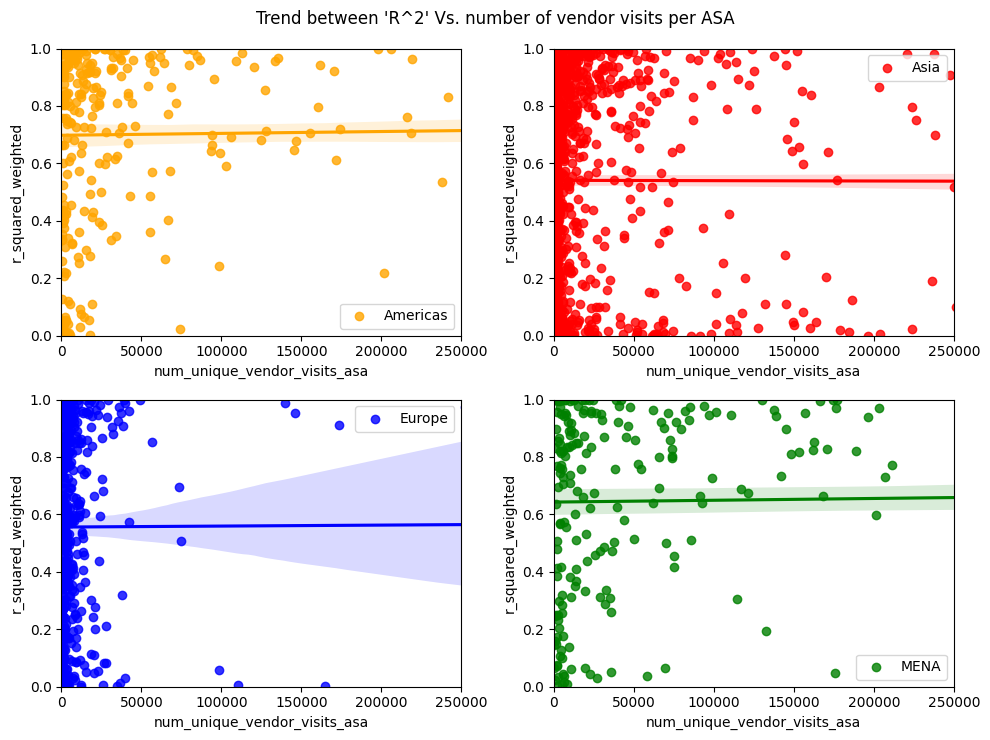

In [42]:
# Plot 1: Scatter plot of visits vs. R-squared
data_plot = df_asa[(df_asa["num_tiers_master_asa"] > 1)]
data_plot["num_tiers_master_asa_bin"] = pd.cut(data_plot["num_tiers_master_asa"], bins=5)
data_plot["num_unique_vendor_visits_asa_bin"] = data_plot.groupby("region")["num_unique_vendor_visits_asa"].transform(lambda x: pd.qcut(x, q=4))
ax_locations_fig_1 = list(zip((0,0,1,1), (0,1,0,1)))
colors_fig_1 = ["orange", "red", "blue", "green"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7.5))

for idx, reg in enumerate(data_plot["region"].unique().tolist()):
    # R^2 Vs. Number of visits (number of transactions would give a similar result)
    sns.regplot(data=data_plot[data_plot["region"] == reg], x="num_unique_vendor_visits_asa", y="r_squared_weighted", ax=axes[ax_locations_fig_1[idx]], color=colors_fig_1[idx], label=reg)
    axes[ax_locations_fig_1[idx]].legend()

# Set the x-axis limits
plt.setp(axes, xlim=(0, 250000), ylim=(0, 1))

# Chart Title
fig.suptitle("Trend between 'R^2' Vs. number of vendor visits per ASA")

# Tight layout
plt.tight_layout()

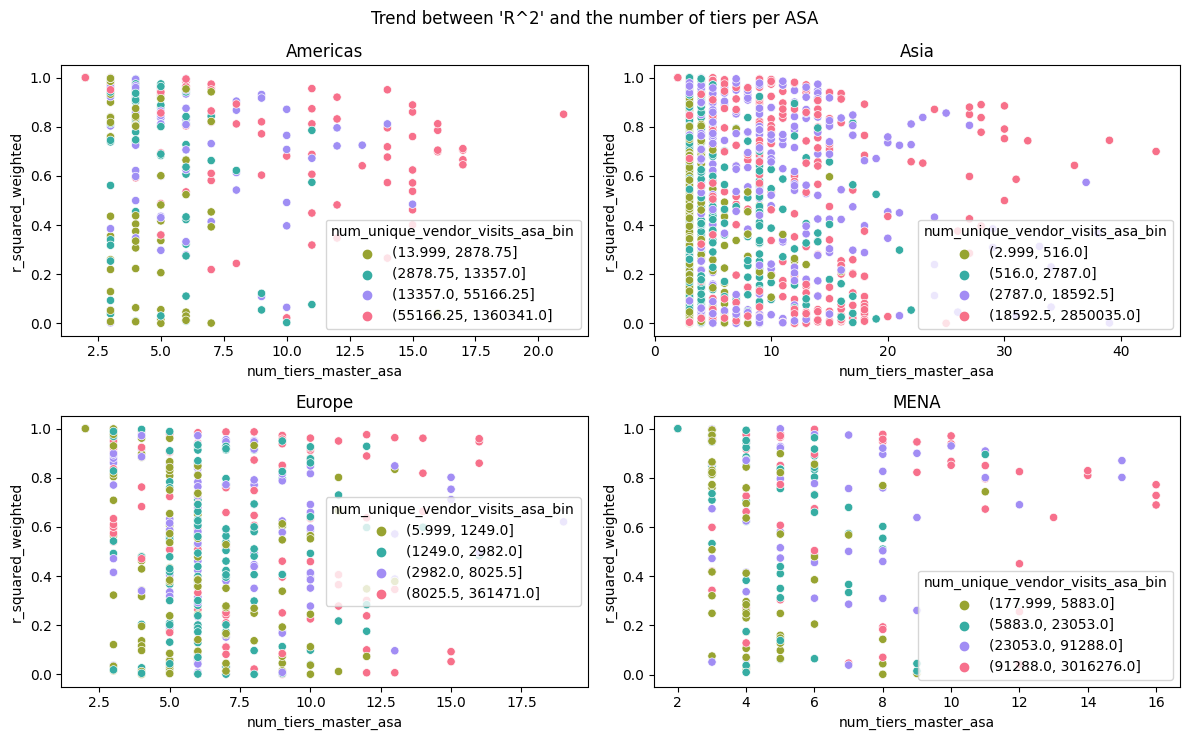

In [43]:
# R^2 Vs. Number of Tiers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7.5))
for idx, reg in enumerate(data_plot["region"].unique().tolist()):
    # R^2 Vs. Number of visits
    sns.scatterplot(
        data=data_plot[data_plot["region"] == reg],
        x="num_tiers_master_asa",
        y="r_squared_weighted",
        ax=axes[ax_locations_fig_1[idx]],
        hue="num_unique_vendor_visits_asa_bin",
        hue_order=data_plot[data_plot["region"] == reg]["num_unique_vendor_visits_asa_bin"].sort_values()
    )
    axes[ax_locations_fig_1[idx]].title.set_text(reg)

# Chart Title
fig.suptitle("Trend between 'R^2' and the number of tiers per ASA")

# Tight layout
plt.tight_layout()


In [44]:
# R^2 correlation with other metrics
data_plot[["r_squared_weighted", "num_unique_vendor_visits_asa", "num_transactions_asa", "num_tiers_master_asa", "coef_weighted"]].corr()

,r_squared_weighted,num_unique_vendor_visits_asa,num_transactions_asa,num_tiers_master_asa,coef_weighted
r_squared_weighted,1.000000,0.023173,0.032169,-0.172202,-0.093118
num_unique_vendor_visits_asa,0.023173,1.000000,0.910616,0.180384,0.004002
num_transactions_asa,0.032169,0.910616,1.000000,0.126587,-0.004994
num_tiers_master_asa,-0.172202,0.180384,0.126587,1.000000,-0.004347
coef_weighted,-0.093118,0.004002,-0.004994,-0.004347,1.000000


In [45]:
# R^2 bin analysis for ASA
df_asa_filtered_tiers = df_asa[df_asa["num_tiers_master_asa"] >= min_tiers].reset_index(drop=True)
# Second, calculate the ASAs' order share of the country and rank them in descending order
entity_id_transaction_tot = df_asa_filtered_tiers.groupby("entity_id")["num_transactions_asa"].transform("sum")
df_asa_filtered_tiers["asa_order_share_of_country"] = df_asa_filtered_tiers["num_transactions_asa"] / entity_id_transaction_tot
df_asa_filtered_tiers["asa_order_share_of_country_rank"] = df_asa_filtered_tiers.groupby("entity_id")["asa_order_share_of_country"].rank(ascending=False)
df_asa_filtered_tiers.sort_values(["entity_id", "asa_order_share_of_country_rank"], ascending=True, inplace=True)

# Create a new data frame containing ASAs with more than four tiers
df_asa_bin_analysis = df_asa_filtered_tiers.copy()

# Rename the coef_weighted column to coef_weighted_pos
df_asa_bin_analysis = df_asa_bin_analysis.rename({"coef_weighted": "coef_weighted_pos"}, axis=1)

# Make a copy of coef_weighted_pos and call it coef_weighted_neg
df_asa_bin_analysis["coef_weighted_neg"] = df_asa_bin_analysis["coef_weighted_pos"]

# Cut the tiers into bins
df_asa_bin_analysis["r_squared_weighted_bin"] = pd.cut(df_asa_bin_analysis["r_squared_weighted"], bins=5)

# Create some helper functions
def pos_slope_counter_func(col):
    return col[col > 0].count()
def neg_slope_counter_func(col):
    return col[col < 0].count()
agg_function_selection = {"num_unique_vendor_visits_asa": "sum", "num_transactions_asa": "sum", "coef_weighted_pos": pos_slope_counter_func, "coef_weighted_neg": neg_slope_counter_func}

# Aggregate on region/entity level
df_asa_bin_analysis_entity_lvl = df_asa_bin_analysis.groupby(["region", "entity_id"])\
    [["num_unique_vendor_visits_asa", "num_transactions_asa", "coef_weighted_pos", "coef_weighted_neg"]].agg(
        agg_function_selection
    ).reset_index()

df_asa_bin_analysis_entity_lvl["coef_weighted_tot"] = df_asa_bin_analysis_entity_lvl["coef_weighted_pos"] + df_asa_bin_analysis_entity_lvl["coef_weighted_neg"]

##----------------------------------------##

# Aggregate on region/entity/bin level
df_asa_bin_analysis_bin_lvl = df_asa_bin_analysis.groupby(["region", "entity_id", "r_squared_weighted_bin"])\
    [["num_unique_vendor_visits_asa", "num_transactions_asa", "coef_weighted_pos", "coef_weighted_neg"]].agg(
        agg_function_selection
    )

# Remove extra rows that appear due to grouping by region
df_asa_bin_analysis_bin_lvl = df_asa_bin_analysis_bin_lvl[df_asa_bin_analysis_bin_lvl["coef_weighted_pos"].notnull()].reset_index()

# Join df_asa_bin_analysis_entity_lvl and df_asa_bin_analysis_bin_lvl
df_asa_bin_analysis_bin_lvl = pd.merge(left=df_asa_bin_analysis_bin_lvl, right=df_asa_bin_analysis_entity_lvl, how="left", on=["region", "entity_id"], suffixes=["_bin", "_entity"])

# Add two additional columns showing the share of visits and orders per bin
df_asa_bin_analysis_bin_lvl = df_asa_bin_analysis_bin_lvl.assign(
    bin_visits_share_of_country = df_asa_bin_analysis_bin_lvl["num_unique_vendor_visits_asa_bin"] / df_asa_bin_analysis_bin_lvl["num_unique_vendor_visits_asa_entity"],
    bin_order_share_of_country = df_asa_bin_analysis_bin_lvl["num_transactions_asa_bin"] / df_asa_bin_analysis_bin_lvl["num_transactions_asa_entity"],
    coef_pos_slope_asa_share_of_country = df_asa_bin_analysis_bin_lvl["coef_weighted_pos_bin"] / df_asa_bin_analysis_bin_lvl["coef_weighted_tot"],
    coef_neg_slope_asa_share_of_country = df_asa_bin_analysis_bin_lvl["coef_weighted_neg_bin"] / df_asa_bin_analysis_bin_lvl["coef_weighted_tot"],
)

df_asa_bin_analysis_bin_lvl

,region,entity_id,r_squared_weighted_bin,num_unique_vendor_visits_asa_bin,num_transactions_asa_bin,coef_weighted_pos_bin,coef_weighted_neg_bin,num_unique_vendor_visits_asa_entity,num_transactions_asa_entity,coef_weighted_pos_entity,coef_weighted_neg_entity,coef_weighted_tot,bin_visits_share_of_country,bin_order_share_of_country,coef_pos_slope_asa_share_of_country,coef_neg_slope_asa_share_of_country
0,Americas,AP_PA,"(-0.000999, 0.2]",4735.0,684.0,0.0,1.0,1050828.0,380019.0,1,22,23,0.004506,0.001800,0.000000,0.043478
1,Americas,AP_PA,"(0.2, 0.4]",128602.0,45701.0,1.0,3.0,1050828.0,380019.0,1,22,23,0.122382,0.120260,0.043478,0.130435
2,Americas,AP_PA,"(0.4, 0.6]",22186.0,6694.0,0.0,4.0,1050828.0,380019.0,1,22,23,0.021113,0.017615,0.000000,0.173913
3,Americas,AP_PA,"(0.6, 0.8]",700735.0,261150.0,0.0,5.0,1050828.0,380019.0,1,22,23,0.666841,0.687202,0.000000,0.217391
4,Americas,AP_PA,"(0.8, 0.999]",194570.0,65790.0,0.0,9.0,1050828.0,380019.0,1,22,23,0.185159,0.173123,0.000000,0.391304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,MENA,TB_OM,"(-0.000999, 0.2]",810912.0,274165.0,2.0,2.0,1236090.0,424779.0,4,11,15,0.656030,0.645430,0.133333,0.133333
187,MENA,TB_OM,"(0.2, 0.4]",11521.0,2404.0,2.0,2.0,1236090.0,424779.0,4,11,15,0.009321,0.005659,0.133333,0.133333
188,MENA,TB_OM,"(0.4, 0.6]",1993.0,285.0,0.0,1.0,1236090.0,424779.0,4,11,15,0.001612,0.000671,0.000000,0.066667
189,MENA,TB_OM,"(0.6, 0.8]",336130.0,120806.0,0.0,3.0,1236090.0,424779.0,4,11,15,0.271930,0.284397,0.000000,0.200000


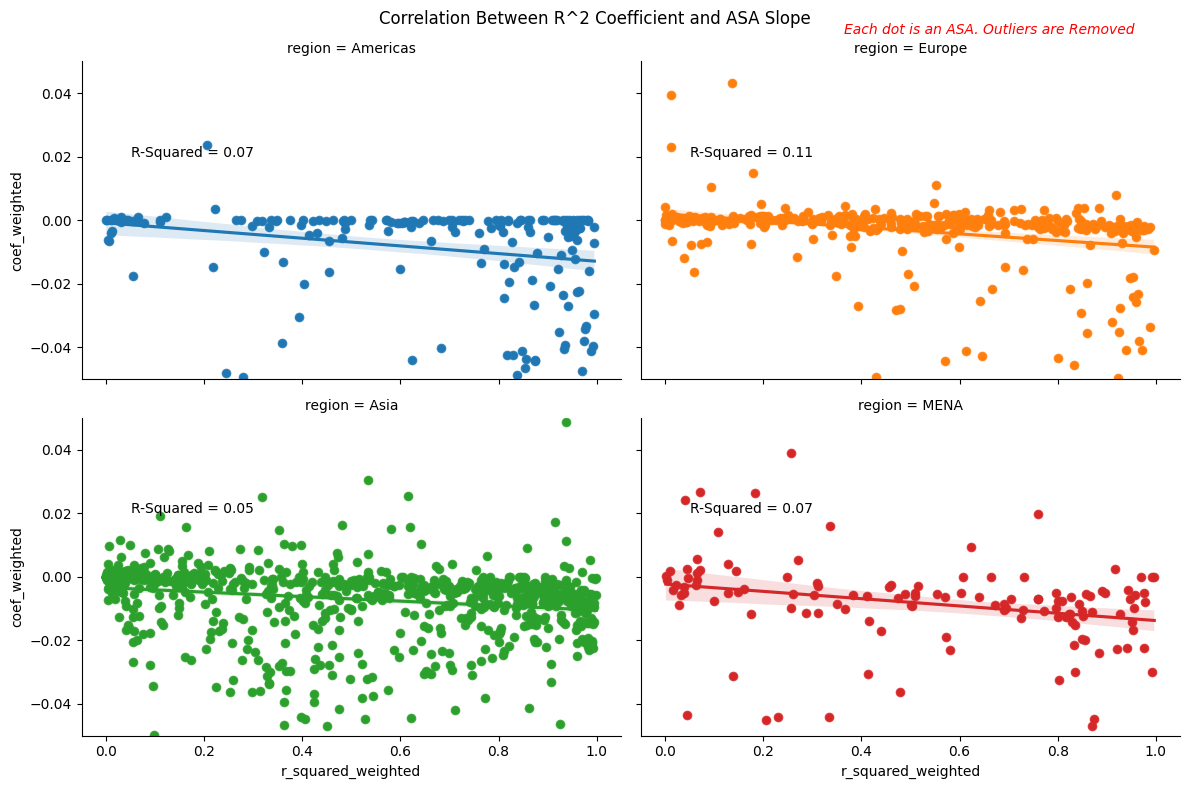

In [46]:
# Plot 1: Correlation between r_squared and coef_weighted
is_plot_1_automated = False
coef_limits_plot_1 = (-0.05, 0.05)

# Join the outlier bounds to the data frame and then filter out the outliers
if is_plot_1_automated == True:
    # First, calculate the outlier bounds per region
    outlier_bounds = list(zip(
    df_asa_filtered_tiers["region"].unique().tolist(),
    df_asa_filtered_tiers.groupby("region")["coef_weighted"].apply(lambda x: np.quantile(x, 0.25) - 1.5 * (np.quantile(x, 0.75) - np.quantile(x, 0.25))),
    df_asa_filtered_tiers.groupby("region")["coef_weighted"].apply(lambda x: np.quantile(x, 0.75) + 1.5 * (np.quantile(x, 0.75) - np.quantile(x, 0.25)))
    ))
    df_outlier_bounds_plot_1 = pd.DataFrame(outlier_bounds, columns=["region", "coef_outlier_lower_bound", "coef_outlier_upper_bound"])

    df_plot_1 = pd.merge(left=df_asa_filtered_tiers, right=df_outlier_bounds_plot_1, on="region", how="left")
    df_plot_1 = df_plot_1[(df_plot_1["coef_weighted"] >= df_plot_1["coef_outlier_lower_bound"]) & (df_plot_1["coef_weighted"] <= df_plot_1["coef_outlier_upper_bound"])]
    y_lim_plot_1 = (df_outlier_bounds_plot_1["coef_outlier_lower_bound"].min(), df_outlier_bounds_plot_1["coef_outlier_upper_bound"].max())
else:
    df_plot_1 = df_asa_filtered_tiers[(df_asa_filtered_tiers["coef_weighted"] >= coef_limits_plot_1[0]) & (df_asa_filtered_tiers["coef_weighted"] <= coef_limits_plot_1[1])]
    y_lim_plot_1 = coef_limits_plot_1

grid = sns.FacetGrid(
    data=df_plot_1,
    col="region",
    hue="region",
    height=4,
    aspect=1.5,
    col_wrap=2
)
grid.map(sns.scatterplot, "r_squared_weighted", "coef_weighted")
grid.map(sns.regplot, "r_squared_weighted", "coef_weighted")

# Compute the R^2 value for each plot
for idx, ax in enumerate(grid.axes):
    slope_plot_1, intercept_plot_1, r_value_plot_1, p_value_plot_1, std_err_plot_1 = linregress(
        df_plot_1[df_plot_1["region"] == grid.col_names[idx]]["r_squared_weighted"],
        df_plot_1[df_plot_1["region"] == grid.col_names[idx]]["coef_weighted"]
    )
    r_squared_plot_1 = r_value_plot_1 ** 2
    ax.annotate(f"R-Squared = {r_squared_plot_1:.2f}", (0.05, 0.02))

# grid.map(plt.annotate, f"R-squared = {r_value_plot_1 ** 2:.2f}")
plt.ylim(y_lim_plot_1)
plt.suptitle("Correlation Between R^2 Coefficient and ASA Slope")
grid.fig.text(0.95, 0.95, "Each dot is an ASA. Outliers are Removed", fontsize=10, ha="right", fontstyle="italic", color="red")
plt.tight_layout()

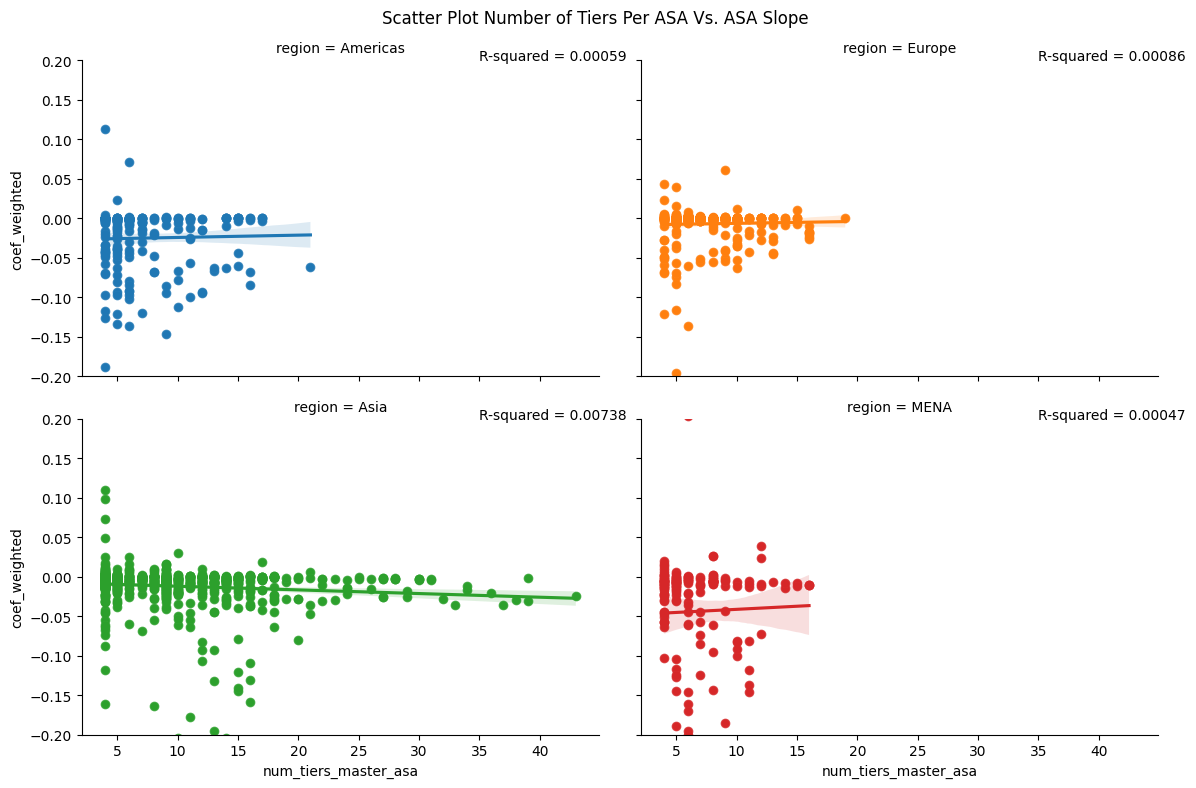

In [47]:
# Plot 2: Scatter Plot Number of Tiers Per ASA Vs. ASA Slope
grid_2 = sns.FacetGrid(
    data=df_asa_filtered_tiers,
    col="region",
    hue="region",
    height=4,
    aspect=1.5,
    col_wrap=2   
)
grid_2.map(sns.scatterplot, "num_tiers_master_asa", "coef_weighted")
grid_2.map(sns.regplot, "num_tiers_master_asa", "coef_weighted")
for idx, ax in enumerate(grid_2.axes):
    slope_plot_2, intercept_plot_2, r_value_plot_2, p_value_plot_2, std_err_plot_2 = linregress(
        df_asa_filtered_tiers[df_asa_filtered_tiers["region"] == grid_2.col_names[idx]]["num_tiers_master_asa"],
        df_asa_filtered_tiers[df_asa_filtered_tiers["region"] == grid_2.col_names[idx]]["coef_weighted"]
    )
    r_squared_plot_2 = r_value_plot_2 ** 2
    ax.annotate(text=f"R-squared = {r_squared_plot_2:.5f}", xy=(35, 0.2))

plt.ylim((-0.2, 0.2))
plt.suptitle("Scatter Plot Number of Tiers Per ASA Vs. ASA Slope")
plt.tight_layout()


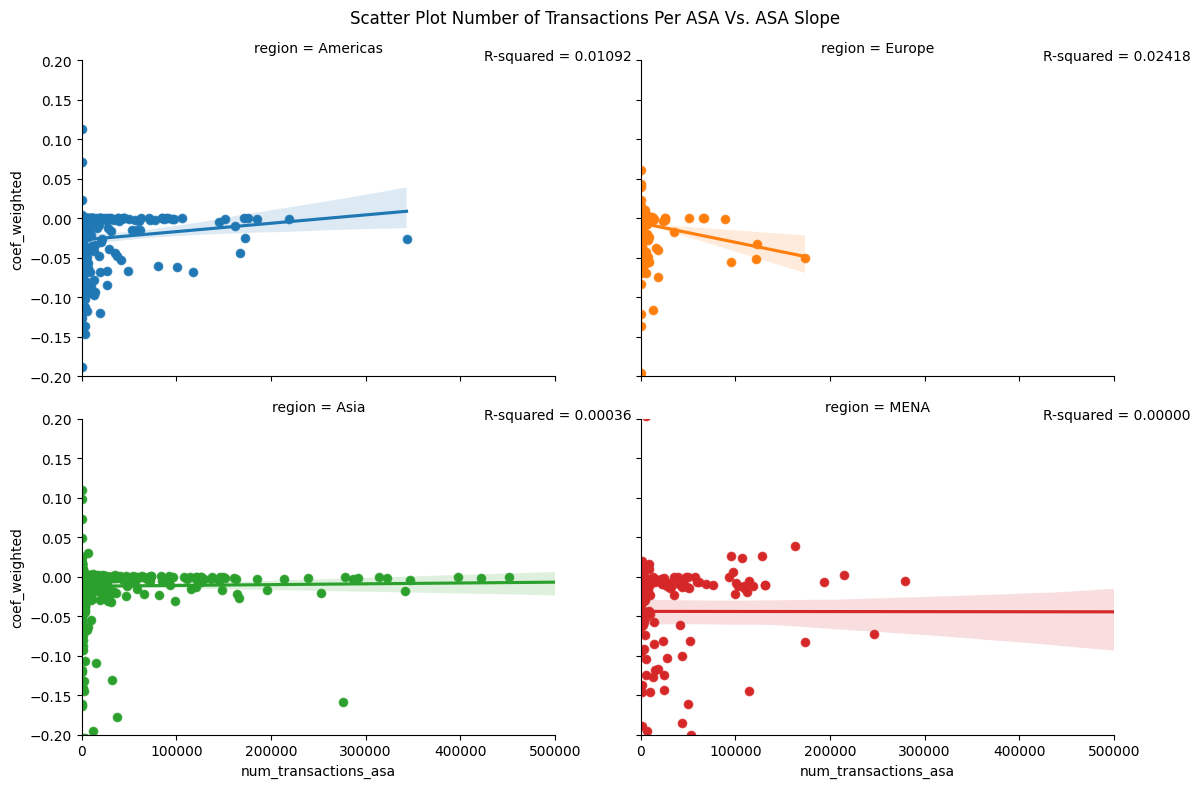

In [48]:
# Plot 3: Scatter Plot Number of Transactions Per ASA Vs. ASA Slope
df_plot_3 = df_asa_filtered_tiers.copy()
grid_3 = sns.FacetGrid(
    data=df_plot_3,
    col="region",
    hue="region",
    height=4,
    aspect=1.5,
    col_wrap=2 
)
grid_3.map(sns.scatterplot, "num_transactions_asa", "coef_weighted")
grid_3.map(sns.regplot, "num_transactions_asa", "coef_weighted")
for idx, ax in enumerate(grid_3.axes):
    slope_plot_3, intercept_plot_3, r_value_plot_3, p_value_plot_3, std_err_plot_3 = linregress(
        df_plot_3[df_plot_3["region"] == grid_3.col_names[idx]]["num_transactions_asa"],
        df_plot_3[df_plot_3["region"] == grid_3.col_names[idx]]["coef_weighted"]
    )
    r_squared_plot_3 = r_value_plot_3 ** 2
    ax.annotate(text=f"R-squared = {r_squared_plot_3:.5f}", xy=(425000, 0.2))

plt.xlim((0, 500000))
plt.ylim((-0.2, 0.2))
plt.suptitle("Scatter Plot Number of Transactions Per ASA Vs. ASA Slope")
plt.tight_layout()


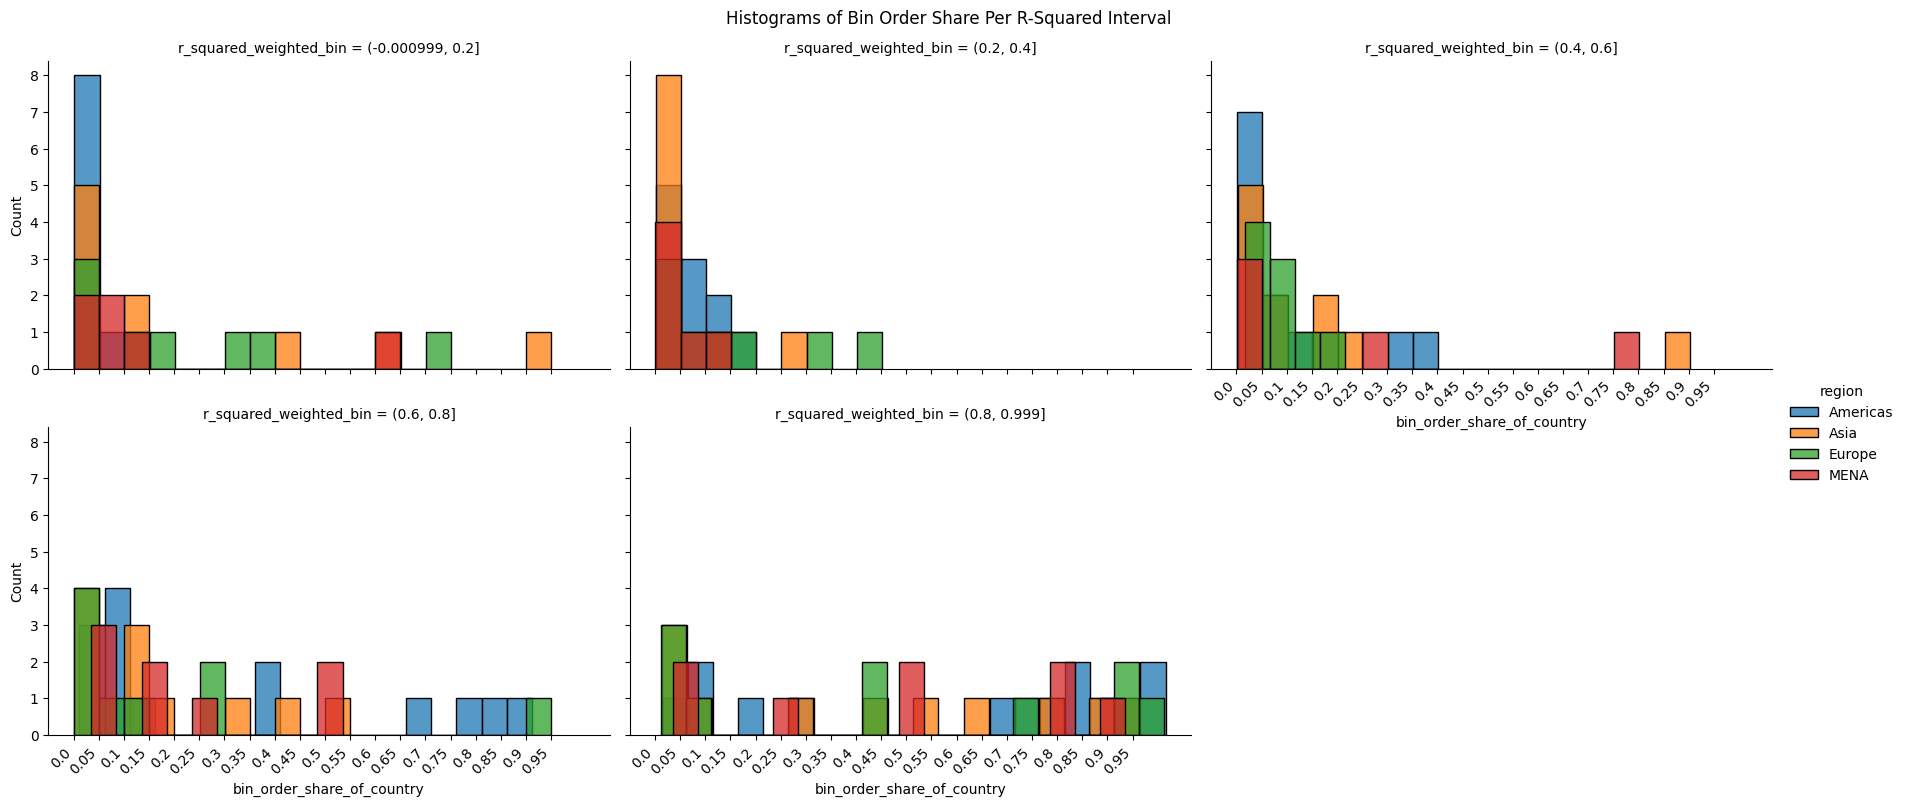

In [49]:
# Plot 4: Order Share Distribution Per Bin (Histogram)
grid_4 = sns.FacetGrid(
    data=df_asa_bin_analysis_bin_lvl,
    col="r_squared_weighted_bin",
    hue="region",
    height=4,
    aspect=1.5,
    col_wrap=3
)
plt.suptitle("Histograms of Bin Order Share Per R-Squared Interval")
plot_4_bin_width = 0.05
grid_4.map(sns.histplot, "bin_order_share_of_country", binwidth=plot_4_bin_width)
for axes in grid_4.axes.flat:
    axes.set_xticks(np.arange(0, 1, plot_4_bin_width), labels=[round(i, 2) for i in list(np.arange(0, 1, plot_4_bin_width))])
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
grid_4.add_legend(legend_data=grid_4._legend_data, bbox_to_anchor=(1, 0.45))

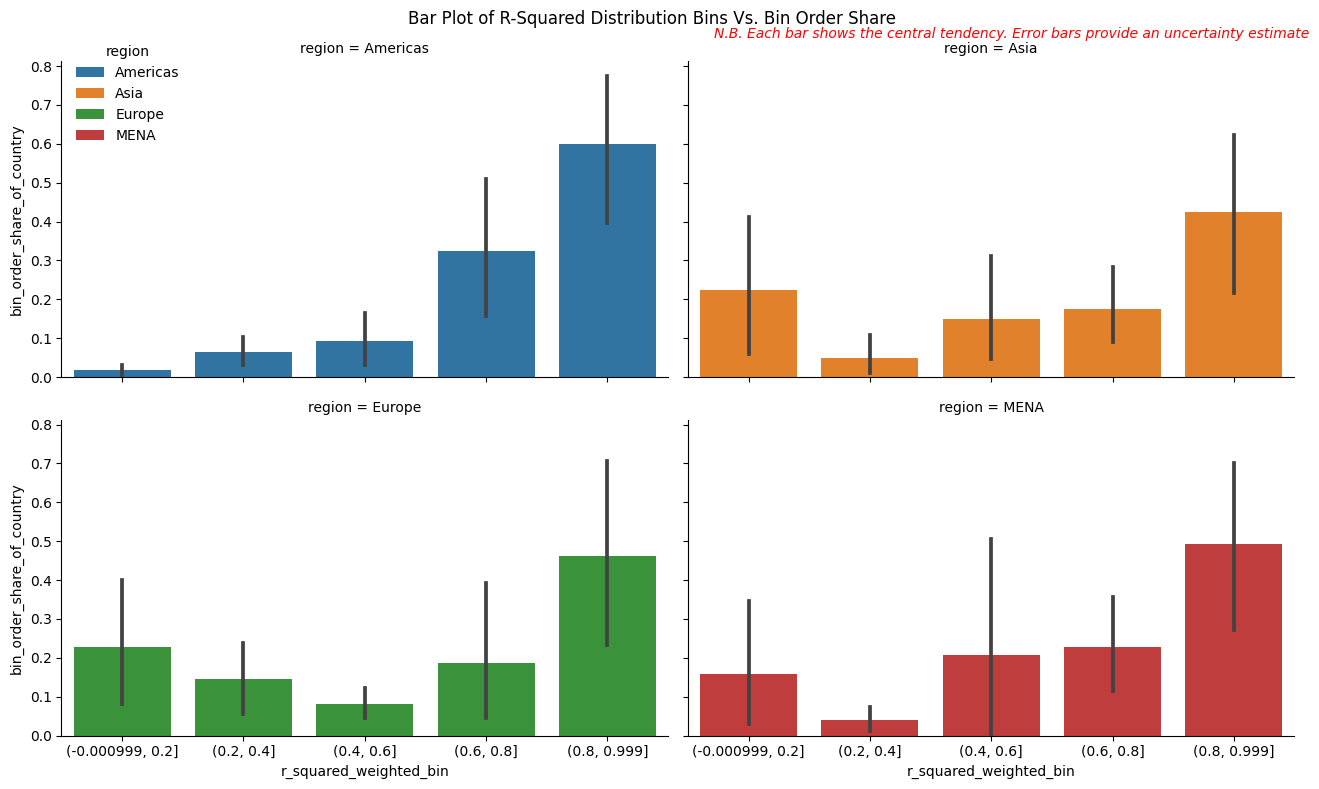

In [50]:
# Plot 5: Order Share Distribution Per Bin (Bar Plot)
grid_5 = sns.FacetGrid(
    data=df_asa_bin_analysis_bin_lvl,
    col="region",
    hue="region",
    height=4,
    aspect=1.5,
    col_wrap=2
)
grid_5.map(sns.barplot, "r_squared_weighted_bin", "bin_order_share_of_country")
grid_5.add_legend(legend_data=grid_5._legend_data, bbox_to_anchor=(0.15, 0.875))
plt.suptitle("Bar Plot of R-Squared Distribution Bins Vs. Bin Order Share")
grid_5.fig.text(1, 0.945, "N.B. Each bar shows the central tendency. Error bars provide an uncertainty estimate", fontsize=10, ha="right", fontstyle="italic", color="red")
plt.tight_layout()

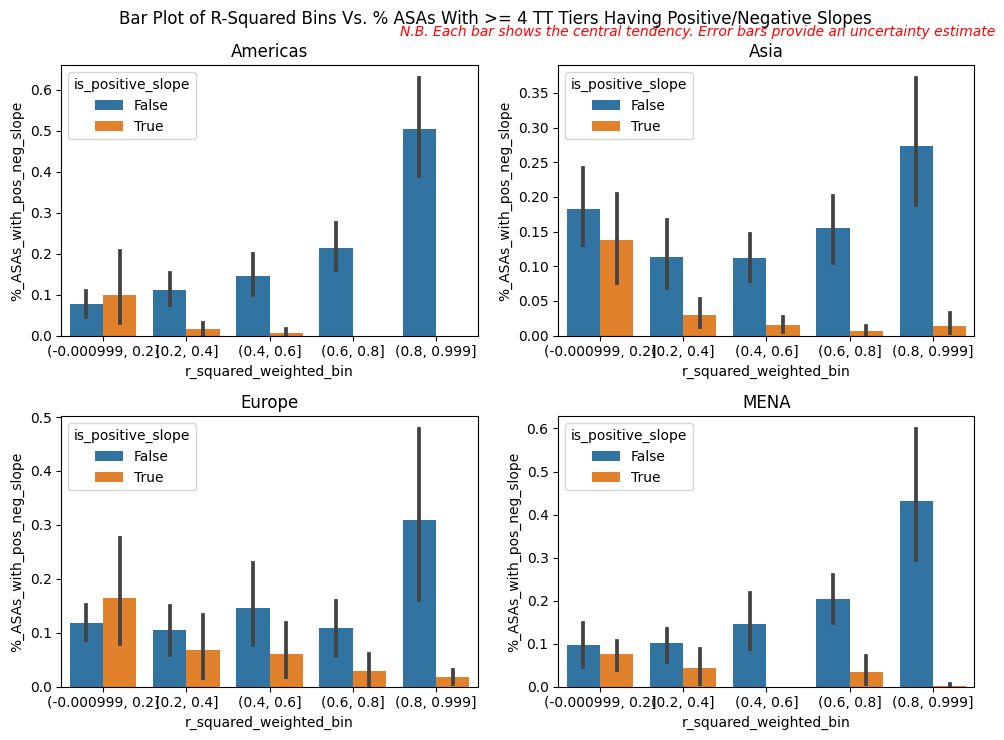

In [51]:
# Plot 6: Share of ASAs with positive and negative per R^2 Interval
df_plot_6 = pd.melt(
    frame=df_asa_bin_analysis_bin_lvl[["region", "entity_id", "r_squared_weighted_bin", "coef_pos_slope_asa_share_of_country", "coef_neg_slope_asa_share_of_country"]],
    id_vars=["region", "entity_id", "r_squared_weighted_bin"],
    var_name="is_positive_slope",
    value_name="%_ASAs_with_pos_neg_slope"
)
df_plot_6["is_positive_slope"] = df_plot_6["is_positive_slope"].apply(lambda x: True if x == "coef_pos_slope_asa_share_of_country" else False)
fig_6, ax_6 = plt.subplots(nrows=2, ncols=2, figsize = (10, 7.5))
ax_locations_fig_6 = list(zip((0,0,1,1), (0,1,0,1)))
for idx, reg in enumerate(df_plot_6["region"].unique().tolist()):
    sns.barplot(data=df_plot_6[df_plot_6["region"] == reg], x="r_squared_weighted_bin", y="%_ASAs_with_pos_neg_slope", hue="is_positive_slope", ax=ax_6[ax_locations_fig_6[idx]])
    ax_6[ax_locations_fig_6[idx]].title.set_text(reg)
fig_6.text(x=1, y=0.945, s="N.B. Each bar shows the central tendency. Error bars provide an uncertainty estimate", fontsize=10, ha="right", fontstyle="italic", color="red")
plt.suptitle(f"Bar Plot of R-Squared Bins Vs. % ASAs With >= {min_tiers} TT Tiers Having Positive/Negative Slopes")
plt.tight_layout()


In [22]:
# Plot 7 (Preliminary step)

# Third, extract the currency conversion rates of all currencies
# Open the JSON file containing the country codes and currencies
with open("country_codes_and_currencies.json", mode="r", encoding="utf-8") as f:
    country_codes_and_currencies = json.load(f)
    country_codes_and_currencies = pd.DataFrame(country_codes_and_currencies)
    f.close()

# Define a function that returns the exchange rate between currency "X" and the EUR
def convert_currency(amount, from_currency, to_currency):
    converted= requests.get(f"https://api.frankfurter.app/latest?amount={float(amount)}&from={from_currency}&to={to_currency}")
    converted = converted.json()['rates'][to_currency]
    return converted

exchange_rate = []
for i in country_codes_and_currencies["currency"]:
    try:
        exchange_rate.append(convert_currency(1, i, "EUR"))
    except KeyError:
        exchange_rate.append(None)
    
    # Insert a sleep between each request
    time.sleep(0.1)

country_codes_and_currencies["exchange_rate"] = exchange_rate

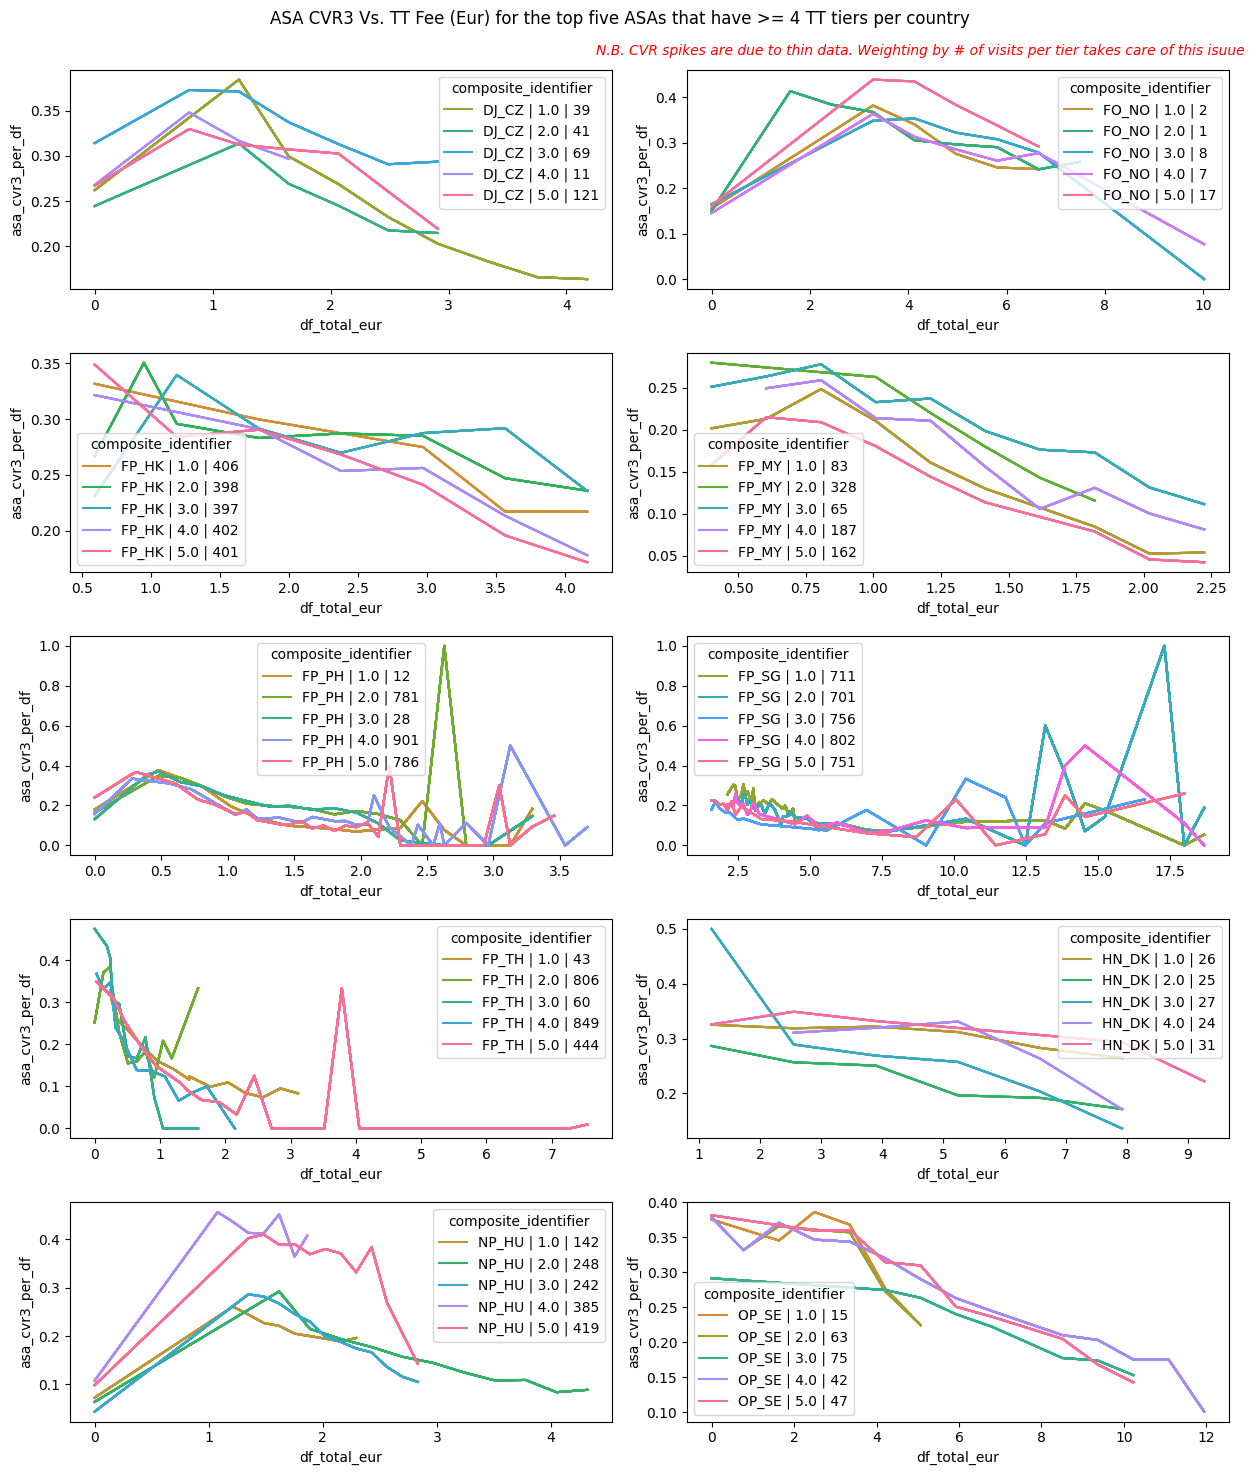

In [52]:
# Plot 7 (Ctd): Plots of the CVR by TT fee for the top ASAs in **each country**

# First, filter df_asa_data_enriched by the number of tiers in an ASA, then create the R^2 bins and change df_total to numeric, and finally add the identifier column
df_cvr_by_tt_fee_asa = df_asa_data_enriched.copy()
df_cvr_by_tt_fee_asa["r_squared_weighted_bin"] = pd.cut(x=df_cvr_by_tt_fee_asa["r_squared_weighted"], bins=5)
df_cvr_by_tt_fee_asa["df_total"] = df_cvr_by_tt_fee_asa["df_total"].apply(lambda x: pd.to_numeric(x))
df_cvr_by_tt_fee_asa = pd.merge(
    left=df_cvr_by_tt_fee_asa,
    right=df_asa_bin_analysis_bin_lvl[["entity_id", "r_squared_weighted_bin", "num_transactions_asa_bin"]],
    on=["entity_id", "r_squared_weighted_bin"],
    how="left"
)
df_cvr_by_tt_fee_asa = df_cvr_by_tt_fee_asa[df_asa_data_enriched["num_tiers_master_asa"] >= min_tiers] # Remove ASAs below 4 tiers

# Second, filter df_cvr_by_tt_fee_asa by the top five ASAs obtained from df_asa_filtered_tiers
df_cvr_by_tt_fee_asa = pd.merge(
    left=df_cvr_by_tt_fee_asa,
    right=df_asa_filtered_tiers[df_asa_filtered_tiers["asa_order_share_of_country_rank"] <= 5][["entity_id", "master_asa_id", "asa_order_share_of_country_rank"]],
    on=["entity_id", "master_asa_id"],
    how="inner"
)

# Create a composite identifier as a new column
df_cvr_by_tt_fee_asa["composite_identifier"] = df_cvr_by_tt_fee_asa.\
    apply(lambda x: x["entity_id"] + " | " + str(x["asa_order_share_of_country_rank"]) + " | " + str(x["master_asa_id"]), axis=1)

# Third, add the exchange_rate and calculate df_total_eur
df_cvr_by_tt_fee_asa = pd.merge(
    left=df_cvr_by_tt_fee_asa,
    right=country_codes_and_currencies[["country_code", "exchange_rate"]],
    on="country_code",
    how="left"
)
df_cvr_by_tt_fee_asa["df_total_eur"] = df_cvr_by_tt_fee_asa["df_total"] * df_cvr_by_tt_fee_asa["exchange_rate"]

# Finally, plot the line graphs
fig_7, ax_7 = plt.subplots(nrows=5, ncols=2, figsize=(12.5, 15))
ax_locations_fig_7 = list(zip((0,0,1,1,2,2,3,3,4,4), (0,1,0,1,0,1,0,1,0,1)))
for idx, cntry in enumerate(df_cvr_by_tt_fee_asa[df_cvr_by_tt_fee_asa["df_total_eur"].notnull()]["entity_id"].unique().tolist()):
    sns.lineplot(
        data=df_cvr_by_tt_fee_asa[df_cvr_by_tt_fee_asa["entity_id"] == cntry],
        x="df_total_eur",
        y="asa_cvr3_per_df",
        hue="composite_identifier",
        hue_order=df_cvr_by_tt_fee_asa[df_cvr_by_tt_fee_asa["entity_id"] == cntry]["composite_identifier"].sort_values(),
        ax=ax_7[ax_locations_fig_7[idx]]
    )
plt.suptitle(f"ASA CVR3 Vs. TT Fee (Eur) for the top five ASAs that have >= {min_tiers} TT tiers per country\n\n")
fig_7.text(x=1, y=0.95, s="N.B. CVR spikes are due to thin data. Weighting by # of visits per tier takes care of this isuue", fontsize=10, ha="right", fontstyle="italic", color="red")
plt.tight_layout()

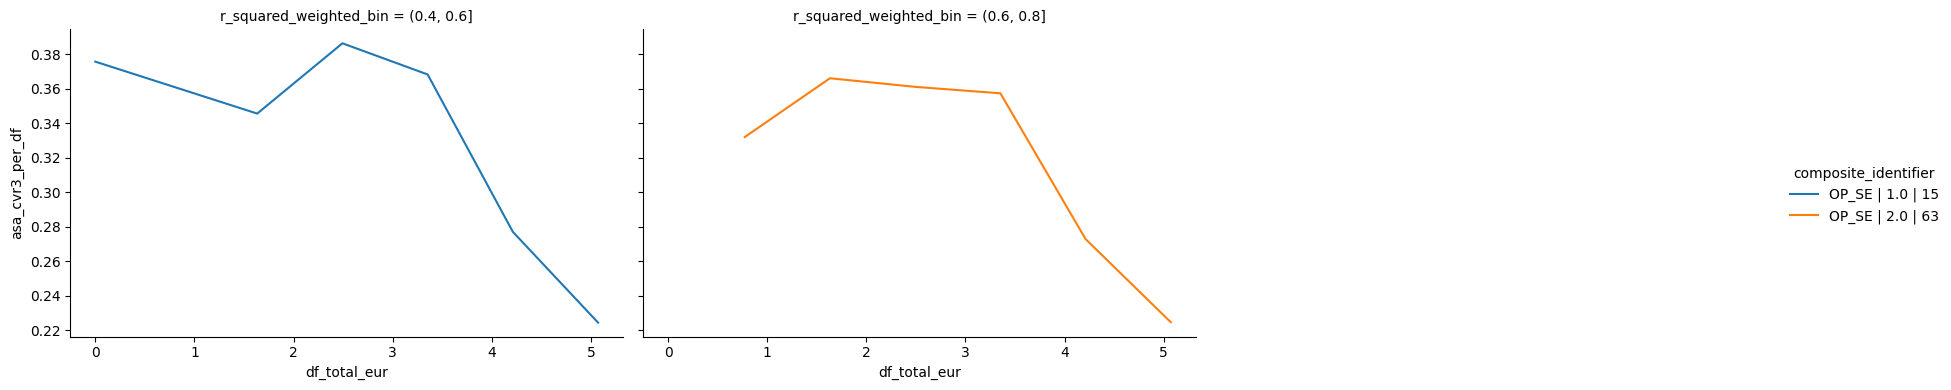

In [53]:
# Plot 8: Plots of the CVR by TT fee for the top ASAs in **each country - bin**
df_cvr_by_tt_fee_asa = df_cvr_by_tt_fee_asa.rename({"num_transactions_asa_bin": "num_transactions_bin"}, axis=1)
df_cvr_by_tt_fee_asa["asa_order_share_of_bin"] = df_cvr_by_tt_fee_asa["num_transactions_asa"] / df_cvr_by_tt_fee_asa["num_transactions_bin"]
df_cvr_by_tt_fee_asa["asa_order_share_of_bin_rank"] = df_cvr_by_tt_fee_asa.\
    groupby(["entity_id", "r_squared_weighted_bin"])["asa_order_share_of_bin"].\
    rank(ascending=False, method="dense")

plot_8_entity = "OP_SE"
grid_8 = sns.FacetGrid(
    data=df_cvr_by_tt_fee_asa[(df_cvr_by_tt_fee_asa["entity_id"] == plot_8_entity) & (df_cvr_by_tt_fee_asa["asa_order_share_of_bin_rank"] <= 5)],
    col="r_squared_weighted_bin",
    hue="composite_identifier",
    height=4,
    aspect=1.5,
    col_wrap=3
)
grid_8.map(sns.lineplot, "df_total_eur", "asa_cvr3_per_df")
grid_8.add_legend()

### Vendor Level Analysis

In [54]:
# Aggregate data on vendor level instead of fee level
df_vendor_data_ven_lvl = df_vendor_data_enriched.groupby(["region", "entity_id", "master_asa_id", "asa_common_name", "vendor_code"]).\
    agg(
        {
            "num_transactions_vendor": np.mean,
            "num_unique_vendor_visits_vendor": np.mean,
            "is_lb_lm": np.unique,
            "num_tiers_vendor": np.mean,
            "coef_weighted": np.mean,
            "coef_non_weighted": np.mean,
            "r_squared_weighted": np.mean,
            "r_squared_non_weighted": np.mean
        },
    ).reset_index()

# Extract the vendor labels from the is_lb_lm list
df_vendor_data_ven_lvl["is_lb_lm"] = df_vendor_data_ven_lvl["is_lb_lm"].apply(lambda x: x[0])

# Add the R^2 bin
df_vendor_data_ven_lvl["r_squared_weighted_bin"] = pd.cut(df_vendor_data_ven_lvl["r_squared_weighted"], bins=5)

# Filter out vendors with less than min_num_tiers
df_vendor_data_ven_lvl_filtered_tiers = df_vendor_data_ven_lvl[df_vendor_data_ven_lvl["num_tiers_vendor"] >= min_tiers]

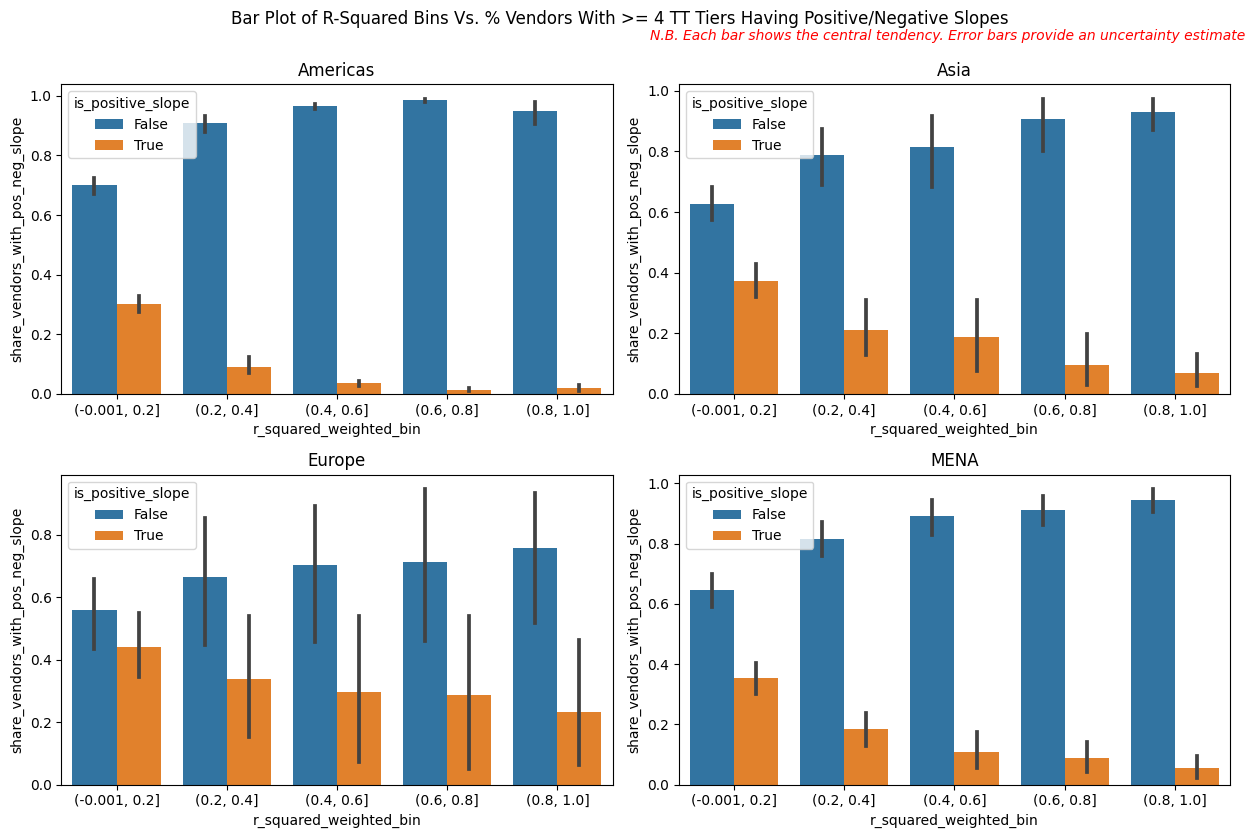

In [55]:
# Plot 8: Share of vendors with positive and negative per R^2 Interval
df_plot_8 = pd.concat(
    [
        df_vendor_data_ven_lvl_filtered_tiers.groupby(["region", "entity_id", "r_squared_weighted_bin"])["coef_weighted"].apply(lambda x: x[x < 0].count() / x.count()).to_frame().rename({"coef_weighted": "coef_weighted_neg"}, axis=1),
        df_vendor_data_ven_lvl_filtered_tiers.groupby(["region", "entity_id", "r_squared_weighted_bin"])["coef_weighted"].apply(lambda x: x[x > 0].count() / x.count()).to_frame().rename({"coef_weighted": "coef_weighted_pos"}, axis=1)
    ],
    axis=1,
).reset_index()

# Delete the NULL rows that result from the concat function
df_plot_8 = df_plot_8[df_plot_8["coef_weighted_neg"].notnull()]

# Rename the columns
df_plot_8_melted = pd.melt(
    frame=df_plot_8,
    id_vars = ["region", "entity_id", "r_squared_weighted_bin"],
    var_name="is_positive_slope",
    value_name="share_vendors_with_pos_neg_slope"    
)

df_plot_8_melted["is_positive_slope"] = df_plot_8_melted["is_positive_slope"].apply(lambda x: False if x == "coef_weighted_neg" else True)

fig_8, ax_8 = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 8.5))
ax_locations_fig_8 = list(zip((0,0,1,1), (0,1,0,1)))
for idx, reg in enumerate(df_plot_8_melted["region"].unique().tolist()):
    sns.barplot(data=df_plot_8_melted[df_plot_8_melted["region"] == reg], x="r_squared_weighted_bin", y="share_vendors_with_pos_neg_slope", hue="is_positive_slope", ax=ax_8[ax_locations_fig_8[idx]])
    ax_8[ax_locations_fig_8[idx]].title.set_text(reg)

plt.suptitle("Bar Plot of R-Squared Bins Vs. % Vendors With >= 4 TT Tiers Having Positive/Negative Slopes\n")
fig_8.text(x=1, y=0.945, s="N.B. Each bar shows the central tendency. Error bars provide an uncertainty estimate", fontsize=10, ha="right", fontstyle="italic", color="red")
plt.tight_layout()

In [56]:
# Sort the table to enable the calculation of cumulative sum
df_vendor_data_ven_lvl = df_vendor_data_ven_lvl.\
    sort_values(["region", "entity_id", "master_asa_id", "num_transactions_vendor"], ascending=[True, True, True, False]).\
    reset_index(drop=True)

# Calculate the cumulative sum of num_transactions_vendor
df_vendor_data_ven_lvl["num_transactions_vendor_asa_cum_sum"] = df_vendor_data_ven_lvl.\
    groupby(["region", "entity_id", "master_asa_id"])["num_transactions_vendor"].\
    transform(lambda x: x.cumsum())

# Calculate the cumulative order share of num_transactions_vendor
df_vendor_data_ven_lvl["share_of_transactions_vendor_asa_cum_sum"] = \
    df_vendor_data_ven_lvl["num_transactions_vendor_asa_cum_sum"] / df_vendor_data_ven_lvl.\
        groupby(["region", "entity_id", "master_asa_id"])["num_transactions_vendor"].transform(lambda x: x.sum())

# Vendor count with an R^2 >= 0.6 AND >= 4 tiers
df_cluster_worthy_asas = df_vendor_data_ven_lvl.\
    groupby(["region", "entity_id", "master_asa_id"]).\
    aggregate({
        "r_squared_weighted": lambda x: x[x >= min_r_squared].count(),
        "num_tiers_vendor": lambda x: x[x >= min_tiers].count(),
        "vendor_code": lambda x: x.count(),
    }).\
    rename(
        {
            "r_squared_weighted": f"num_vendors_r_squared_bigger_than_{min_r_squared}",
            "num_tiers_vendor": f"num_vendors_tiers_bigger_than_{min_tiers}",
            "vendor_code": f"num_vendors_tot",
        },
        axis=1
    ).\
    reset_index()

# Add the shares
df_cluster_worthy_asas[f"share_vendors_r_squared_bigger_than_{min_r_squared}"] = df_cluster_worthy_asas[f"num_vendors_r_squared_bigger_than_{min_r_squared}"] / df_cluster_worthy_asas["num_vendors_tot"]
df_cluster_worthy_asas[f"share_vendors_tiers_bigger_than_{min_tiers}"] = df_cluster_worthy_asas[f"num_vendors_tiers_bigger_than_{min_tiers}"] / df_cluster_worthy_asas["num_vendors_tot"]

# Merge some other data about the ASAs from df_asa
df_cluster_worthy_asas = pd.merge(
    left=df_cluster_worthy_asas,
    right=df_asa[["entity_id", "master_asa_id", "asa_common_name", "num_tiers_master_asa", "r_squared_weighted"]],
    how="left",
    on=["entity_id", "master_asa_id"]
)

# Move the ASA common_name column to the beginning of the data frame
col_to_be_moved = df_cluster_worthy_asas.pop("asa_common_name")
df_cluster_worthy_asas.insert(loc=3, column="asa_common_name", value=col_to_be_moved)
df_cluster_worthy_asas

,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
0,Americas,AP_PA,4,DBDF-3 Pa City (Food): DF:(1.99-2.25-2.49) MOV...,3,5.0,5,0.6,1.0,7.0,0.848268
1,Americas,AP_PA,17,New Partners New Verticals,0,0.0,2,0.0,0.0,1.0,NaN
2,Americas,AP_PA,19,No DBDF Group 3 (Food): DF: (3) MOV: (3),0,0.0,3,0.0,0.0,1.0,NaN
3,Americas,AP_PA,20,No DBDF Group 4 (Food): DF: (3.50) MOV: (3),0,0.0,1,0.0,0.0,1.0,NaN
4,Americas,AP_PA,26,Perfiles Super 99 Growth (NV): DF:(1.99) MOV: (3),0,0.0,2,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2765,MENA,YS_TR,257,YSM MOV 80 - Senaryo 3X80,0,0.0,3,0.0,0.0,1.0,NaN
2766,MENA,YS_TR,259,YSM MOV 85 - Senaryo 1Y85,0,0.0,2,0.0,0.0,1.0,NaN
2767,MENA,YS_TR,260,YSM MOV 85 - Senaryo 2Y85,0,0.0,3,0.0,0.0,1.0,NaN
2768,MENA,YS_TR,261,YSM MOV 85 - Senaryo 3Y85,0,0.0,5,0.0,0.0,1.0,NaN


In [57]:
# Checking some ASAs of upcoming, current, and past tests

# ASAs in Dubai (upcoming tests)
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="TB_AE") & (df_cluster_worthy_asas["master_asa_id"].isin([254, 255]))])

# ASAs in Oman (previous tests in Maabilah and Bosher)
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="TB_OM") & (df_cluster_worthy_asas["master_asa_id"].isin([26, 29]))])

# ASAs in Peru (previous tests in AQP and TRU)
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="PY_PE") & (df_cluster_worthy_asas["master_asa_id"].isin([4, 16]))])

# ASAs in Costa Rica (current tests in San Jose)
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="PY_CR") & (df_cluster_worthy_asas["master_asa_id"].isin([15, 64]))])

# ASAs in Thailand (current and previous tests)
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="FP_TH") & (df_cluster_worthy_asas["master_asa_id"].isin([438, 1098, 795, 2011, 806, 520, 141]))])

# ASAs in PH
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="FP_PH") & (df_cluster_worthy_asas["master_asa_id"].isin([22, 25, 185, 23, 10, 522]))])
display(df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="FP_PH") & (df_cluster_worthy_asas["master_asa_id"].isin([786, 787, 788, 901, 902, 903]))])

# Command to find good ASAs
# df_cluster_worthy_asas[(df_cluster_worthy_asas["entity_id"]=="FP_TH")].sort_values(["num_vendors_tot", "r_squared_weighted"], ascending=False).head(50)

,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
2594,MENA,TB_AE,254,Dubai - Area Based Pricing MOV 10 + SF,0,2.0,2,0.000000,1.0,9.0,0.014819
2595,MENA,TB_AE,255,Dubai - Area Based Pricing MOV 20 + SF,311,854.0,861,0.361208,0.99187,11.0,0.672856


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
2701,MENA,TB_OM,26,Default DBDF - Maabilah/FOOD/MOV08,37,85.0,85,0.435294,1.0,8.0,0.070287
2703,MENA,TB_OM,29,Default DBDF - Bosher/FOOD/MOV08,56,123.0,124,0.451613,0.991935,8.0,0.183533


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
273,Americas,PY_PE,4,"AQP - Restaurants - DF: 87 (1.9, 2.4, 2.9, 3.4...",62,112.0,112,0.553571,1.0,5.0,0.856170
277,Americas,PY_PE,16,"TRU - Restaurants - DF: 89 (1.9, 2.4, 2.9, 3.4...",46,87.0,87,0.528736,1.0,5.0,0.935336


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
180,Americas,PY_CR,15,Restaurants | San Jose - Scheme id: 176,203,331.0,331,0.613293,1.0,7.0,0.819246
187,Americas,PY_CR,64,"Restaurants | Growth 01 - Ciudad quesada, Guap...",25,43.0,43,0.581395,1.0,4.0,0.347512


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
1161,Asia,FP_TH,141,RESTO - City Default - Sakon nakhon,26,54.0,54,0.481481,1.0,9.0,0.975450
1189,Asia,FP_TH,438,RESTO - City Default - Bangkok - Bangkapi,229,536.0,540,0.424074,0.992593,30.0,0.790704
1226,Asia,FP_TH,520,RESTO - City Default - Lamphun - Lamphun east,7,115.0,115,0.060870,1.0,15.0,0.146961
1340,Asia,FP_TH,806,RESTO - City Default - Surat Thani - Chaweng,13,70.0,70,0.185714,1.0,12.0,0.000136
1464,Asia,FP_TH,1098,RESTO - City Default - Nakhon Si Thammarat - N...,76,107.0,108,0.703704,0.990741,13.0,0.970471
1760,Asia,FP_TH,2011,RESTO - Non-chain - Profitable - Samut Sakhon,29,38.0,38,0.763158,1.0,13.0,0.858583


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted


,region,entity_id,master_asa_id,asa_common_name,num_vendors_r_squared_bigger_than_0.4,num_vendors_tiers_bigger_than_4,num_vendors_tot,share_vendors_r_squared_bigger_than_0.4,share_vendors_tiers_bigger_than_4,num_tiers_master_asa,r_squared_weighted
906,Asia,FP_PH,786,Resto - All - Pampanga,3,199.0,199,0.015075,1.0,30.0,4.995542e-01
907,Asia,FP_PH,787,"Resto - McDo, JFC, KFC - Bacoor north, Bacoor ...",0,12.0,12,0.000000,1.0,25.0,7.821836e-07
908,Asia,FP_PH,788,Resto - All - Bacolod,36,122.0,122,0.295082,1.0,31.0,5.862315e-01
914,Asia,FP_PH,901,Resto - All - Davao - Davao,28,248.0,250,0.112000,0.992,28.0,3.962543e-01
915,Asia,FP_PH,902,Resto - All - Misamis oriental,9,155.0,155,0.058065,1.0,27.0,2.849792e-01
916,Asia,FP_PH,903,Resto - All - Iloilo,3,96.0,96,0.031250,1.0,26.0,3.752011e-01


<AxesSubplot:xlabel='df_total', ylabel='cvr3'>

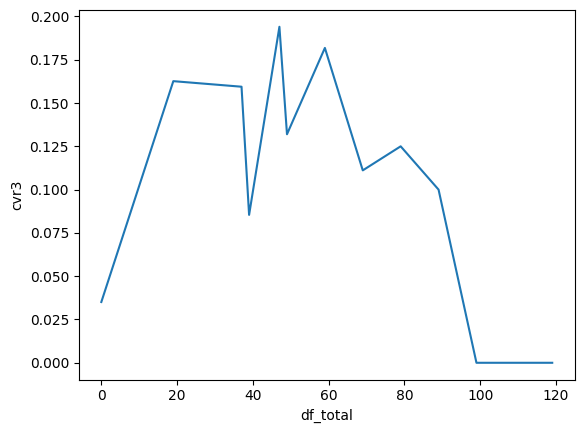

In [58]:
# Random vendor chart
df_vendor_data_ven_lvl[(df_vendor_data_ven_lvl["entity_id"] =="FP_PH") & (df_vendor_data_ven_lvl["master_asa_id"] ==788)]
sns.lineplot(data=df_vendor_data_enriched[(df_vendor_data_enriched["entity_id"]=="FP_PH") * (df_vendor_data_enriched["vendor_code"]=="c6ef")], x="df_total", y="cvr3")

In [64]:
# Random analysis
x = df_asa_data_enriched.groupby(["entity_id", "master_asa_id"], as_index=False)[["coef_weighted", "coef_non_weighted", "r_squared_weighted", "r_squared_non_weighted", "num_tiers_master_asa"]].mean()
x = x[x["num_tiers_master_asa"] > 1]

x["coef_weighted_pos_or_neg"] = x["coef_weighted"].apply(lambda x: "pos" if x > 0 else "neg")
x["coef_non_weighted_pos_or_neg"] = x["coef_non_weighted"].apply(lambda x: "pos" if x > 0 else "neg")

x["r_squared_weighted_bins"] = pd.cut(x["r_squared_weighted"], bins=5)
x["r_squared_non_weighted_bins"] = pd.cut(x["r_squared_non_weighted"], bins=5)

print(x["coef_weighted_pos_or_neg"].value_counts())
print(x["coef_non_weighted_pos_or_neg"].value_counts())

print(x["r_squared_weighted_bins"].value_counts().sort_index())
print(x["r_squared_non_weighted_bins"].value_counts().sort_index())

neg    1765
pos     527
Name: coef_weighted_pos_or_neg, dtype: int64
neg    1799
pos     493
Name: coef_non_weighted_pos_or_neg, dtype: int64
(-0.001, 0.2]    494
(0.2, 0.4]       262
(0.4, 0.6]       321
(0.6, 0.8]       363
(0.8, 1.0]       852
Name: r_squared_weighted_bins, dtype: int64
(-0.001, 0.2]    476
(0.2, 0.4]       244
(0.4, 0.6]       328
(0.6, 0.8]       399
(0.8, 1.0]       845
Name: r_squared_non_weighted_bins, dtype: int64


In [65]:
# Random analysis
x = df_vendor_data_enriched.groupby(["entity_id", "master_asa_id", "vendor_code"], as_index=False)[["coef_weighted", "coef_non_weighted", "r_squared_weighted", "r_squared_non_weighted", "num_tiers_vendor"]].mean()
x = x[x["num_tiers_vendor"] > 1]

x["coef_weighted_pos_or_neg"] = x["coef_weighted"].apply(lambda x: "pos" if x > 0 else "neg")
x["coef_non_weighted_pos_or_neg"] = x["coef_non_weighted"].apply(lambda x: "pos" if x > 0 else "neg")

x["r_squared_weighted_bins"] = pd.cut(x["r_squared_weighted"], bins=5)
x["r_squared_non_weighted_bins"] = pd.cut(x["r_squared_non_weighted"], bins=5)

print(x["coef_weighted_pos_or_neg"].value_counts())
print(x["coef_non_weighted_pos_or_neg"].value_counts())

print(x["r_squared_weighted_bins"].value_counts().sort_index())
print(x["r_squared_non_weighted_bins"].value_counts().sort_index())

neg    64378
pos    20008
Name: coef_weighted_pos_or_neg, dtype: int64
neg    64935
pos    19451
Name: coef_non_weighted_pos_or_neg, dtype: int64
(-0.001, 0.2]    30598
(0.2, 0.4]       14127
(0.4, 0.6]       12271
(0.6, 0.8]       11946
(0.8, 1.0]       15444
Name: r_squared_weighted_bins, dtype: int64
(-0.001, 0.2]    28288
(0.2, 0.4]       14551
(0.4, 0.6]       13051
(0.6, 0.8]       12951
(0.8, 1.0]       15545
Name: r_squared_non_weighted_bins, dtype: int64
